# 5. Interval Newton method

Let's go back to thinking about solving equations, i.e. finding *roots* of functions.

In standard (i.e. non-interval) numerical analysis, the [**Newton** (or Newton--Raphson) method] is a powerful method for (sometimes) finding roots, given by the iterative method

$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}.$$

This has the geometric interpretation of starting from $(x_n, 0)$, moving vertically until you hit the graph of $f$, then following the **tangent line** at the point $(x_n, f(x_n))$ until it intersects the $x$-axis, which gives the new approximation.

If the initial condition is close enough to a root, then then algorithm converges very fast. *But* it is often very difficult to know when you are "close enough". If you don't start close enough then the algorithm can diverge, oscillate, behave chaotically, etc.

Furthermore, if we would like to find *all* the roots of a given function in a given interval, we are out of luck: we can never know (for a general function) whether there are or are not more roots available.

Interval methods provide a solution to these problems, providing a method that in principle can find and verify
all simple roots of a function in a box.

## Interval Newton method

In [1]:
using IntervalArithmetic, ForwardDiff

The interval Newton method is an apparently simple modification of the standard Newton method, but which has superpowers! When correctly implemented, it *guarantees* not to miss any roots, and to home in on the roots that are present at a certain speed in 1D. In higher dimensions there similar guarantees.

We do *not* just run the above algorithm using intervals; this will lead to intervals that grow over time and give useless results. Rather we must refine the algorithm to take *advantage* of the fact that we have information over a whole set.

Suppose we start with an initial interval $X_0$; this is the interval in which we wish to find roots of $f$. 

We will partially mimic the standard Newton method by picking a *single* point in the interval to start from; a standard, but not obligatory, choice is the midpoint $m := \text{mid}(X)$, sometimes denoted $\check{X}$.

We move up to the graph at $(m, f(m))$. But now instead of picking the tangent line, we pick *all possible directions simultaneously*, where the direction is determined by *a possible value of the derivative $f'(x)$*.
An operational version of this is:

$$N_f(X) := m(X) - \frac{f(m(X))}{f'(X)}$$

Note that we are calculating an enclosure of the derivative over the *whole* interval; this will contain all possible derivatives over the interval. 

It turns out that the mean-value theorem now tells us that *any root of $f$ must be hit by one of these sloped lines*. Note that intervals are enabling us to make the mean-value theorem into a *constructive* method.

[Technical note: To bound rounding errors, $m(X)$ must be treated as an interval with 0 width when calculating $f(m)$.]

## Using the interval Newton operator

The following two theorems can be shown:

- If $N_f(X) \subset X$ then there is a unique zero of $f$ in $X$ (by a contraction argument).

- If $N_f(X) \cap X = \emptyset$ then there are no roots of $f$ in $X$ (by the above argument using the mean-value theorem).

#### Exercise

1. Implement this and try some examples.


2. Once you have found a box $X$ in which you have located a root, iterate the Newton operator (i.e. apply it repeatedly) to that box. It will shrink down quadratically fast to a tiny interval containing the root!

## Division by zero

Often, $f'$ will hit zero somewhere in $X$. In this case the division seems not to make any sense, or will return $[-\infty, \infty]$.

But in fact there will always be a region which is excluded from $f'(X)$ near $\pm \infty$, which will lead to an excluded region around $0$ in $1 / f'(X)$. We cannot represent this with a single interval, but we can using the union of *two* intervals.

#### Exercise

1. Implement this "extended division".

In [2]:
(1..2) / (-1..1)   # x / y for x in X, y in Y

[-∞, ∞]

In [3]:
extended_div(1..2, -1..1)

([-∞, -1], [1, ∞])

## Higher dimensions

The Newton interval method extends to functions $f: \mathbb{R}^n \to \mathbb{R}^n$, but now the derivative becomes the Jacobian matrix $\mathsf{J}$, and we replace $1 / f'(X)$ with the matrix inverse, giving

$$N_f(X) := m(X) - \mathsf{J}(m(X))^{-1} f(m(X))$$

The same theorem holds as stated for 1D above on the uniqueness or absence of roots in a given box!

To calculate this numerically we use Julia's `\` operator from the `LinearAlgebra` standard library to solve the  linear system of interval equations. This will give as an over-approximation of the result.

[This usually works, but we have had some issues, in particular when using `StaticArrays.jl`. We are still trying to iron this out. There are many techniques to solve linear systems of interval equations.]

In [4]:
isinf(Inf)

true

In [5]:
isinf(3..Inf)

false

#### Exercise

1. Implement this. Use it to locate a root of

    $g(x, y) = (x^2 + y^2 - 1, x + y)$.
    
    Hint: You will need to start close enough to a root.

In [6]:
using Plots

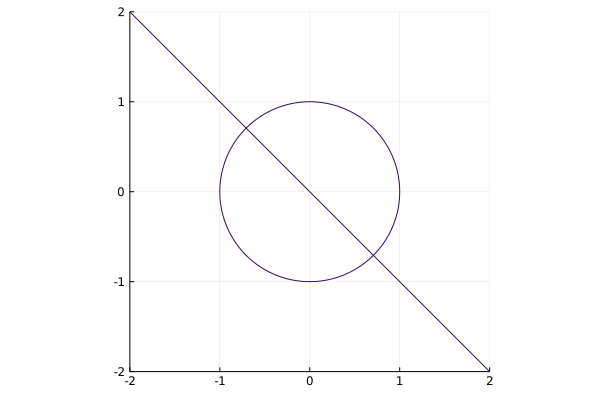

In [24]:
f(x, y) = x^2 + y^2 - 1
g(x, y) = x + y

r = -5:0.01:5

contour(r, r, f, leg=false, ratio=1, levels=[0])
contour!(r, r, g, levels=[0], xlim=(-2, 2), ylim=(-2, 2))

In [11]:
X = (0.7..0.9) × (-1..(-0.5))

[0.699999, 0.900001] × [-1, -0.5]

$$N_f(X) := m(X) - \mathsf{J}(m(X))^{-1} f(m(X))$$


In [12]:
mid(X)

2-element StaticArrays.SArray{Tuple{2},Float64,1,2} with indices SOneTo(2):
  0.8
 -0.75

In [25]:
h( (x, y) ) = SVector(f(x, y), g(x, y))

h (generic function with 1 method)

In [17]:
using StaticArrays

In [27]:
ForwardDiff.jacobian(g, X::IntervalBox) = ForwardDiff.jacobian(g, X.v)

In [20]:
dump(X)

IntervalBox{2,Float64}
  v: SArray{Tuple{2},Interval{Float64},1,2}
    data: Tuple{Interval{Float64},Interval{Float64}}
      1: Interval{Float64}
        lo: Float64 0.7
        hi: Float64 0.9
      2: Interval{Float64}
        lo: Float64 -1.0
        hi: Float64 -0.5


In [31]:
J = ForwardDiff.jacobian(h, big(X))

2×2 SArray{Tuple{2,2},Interval{BigFloat},2,4} with indices SOneTo(2)×SOneTo(2):
        [1.39999, 1.80001]₂₅₆  [-2, -1]₂₅₆
 [1, 1]₂₅₆                       [1, 1]₂₅₆

In [30]:
m = IntervalBox(mid(X))

[0.8, 0.800001] × [-0.75, -0.75]

In [34]:
N(h, X) = (m = IntervalBox(mid(X)); m - J \ h(m) )

N (generic function with 1 method)

In [37]:
X = N(h, X) ∩ X

[0.699999, 0.733553]₂₅₆ × [-0.720395, -0.694791]₂₅₆

In [40]:
N(h, X)

[0.7031, 0.710556]₂₅₆ × [-0.708458, -0.706926]₂₅₆

In [41]:
X

[0.699999, 0.733553]₂₅₆ × [-0.720395, -0.694791]₂₅₆

In [42]:
for i in 1:5
    X = N(h, X)
    
    @show X
end

X = [0.7031, 0.710556]₂₅₆ × [-0.708458, -0.706926]₂₅₆
X = [0.706941, 0.707368]₂₅₆ × [-0.70726, -0.706863]₂₅₆
X = [0.707075, 0.70713]₂₅₆ × [-0.70713, -0.707094]₂₅₆
X = [0.707104, 0.707111]₂₅₆ × [-0.707109, -0.707104]₂₅₆
X = [0.707106, 0.707108]₂₅₆ × [-0.707108, -0.707106]₂₅₆


In [43]:
J

2×2 SArray{Tuple{2,2},Interval{BigFloat},2,4} with indices SOneTo(2)×SOneTo(2):
        [1.39999, 1.80001]₂₅₆  [-2, -1]₂₅₆
 [1, 1]₂₅₆                       [1, 1]₂₅₆

In [44]:
inv(J)

2×2 SArray{Tuple{2,2},Interval{BigFloat},2,4} with indices SOneTo(2)×SOneTo(2):
  [0.263157, 0.416667]₂₅₆   [0.263157, 0.833334]₂₅₆
 [-0.416667, -0.263157]₂₅₆  [0.368421, 0.750001]₂₅₆